In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from scipy.stats import spearmanr


In [2]:
DB_HOST = "localhost"
DB_PORT = 27017
DB_NAME = "reddit_neet_updated"
COLLECTION = "submissions"

In [3]:
client = MongoClient(DB_HOST, DB_PORT)

db = client[DB_NAME]

In [483]:
author_post = list(db[COLLECTION].aggregate([
    {"$match":{"type":"post","author_name":{"$ne":"AutoModerator"}}},
    {"$project":{"author_name":1}},
    {"$group":{"_id":"$author_name","post":{"$sum":1}}}
]))


In [484]:
data_p = pd.DataFrame(author_post)

In [485]:
author_comment = list(db[COLLECTION].aggregate([
    {"$match":{"type":"comment","author_name":{"$ne":"AutoModerator"}}},
    {"$project":{"author_name":1}},
    {"$group":{"_id":"$author_name","comment":{"$sum":1}}}
]))


In [486]:
data_c= pd.DataFrame(author_comment)

In [487]:
author_entities = list(db[COLLECTION].aggregate([
    {
        "$match":{
            "type":"post",
            "author_name":
                {
                    "$ne":"AutoModerator"
                },
            "dbpedia_entities.0":{"$exists":True},
            "dbpedia_entities.similarityScore":{
                "$gte":0.7
            }
        }
    },{
        "$project":{
            "author_name":1,
            "dbpedia_entities.URI":1
        }
    },{
        "$unwind":"$dbpedia_entities"
    },{
        "$project":{
            "author_name":1,
            "entity":"$dbpedia_entities.URI"
        }
    },{
        "$group":{
            "_id":{
                "author_name":"$author_name",
                "entity":"$entity"
            },
            "count":{
                "$sum":1
            }
        }
    },{
        "$group":{
            "_id":"$_id.author_name",
            "entities":{
                "$push":{
                    "entity":"$_id.entity",
                    "count":"$count"
                }
            }
        }
    }
]))


In [488]:
author_df = pd.DataFrame()
for a in author_entities:
    l=list(map(lambda x: {x["entity"]:x["count"]},a["entities"]))
    df = pd.DataFrame({k:v for element in l for k,v in element.items()} ,index=[a["_id"]])
    author_df = author_df.append(df)

author_df.fillna(0,inplace=True)


/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [489]:
data = data_p.set_index('_id').join(data_c.set_index('_id'))

In [490]:
data.fillna(0,inplace=True)

In [491]:
X = data.values
cluster_range = range(2,11)
distortions = []
for k in cluster_range:
    km = KMeans(n_clusters=k)
    km.fit(X)

    labels = km.labels_
    distortions.append(sum(np.min(
        cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [492]:
X.shape

(733, 2)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

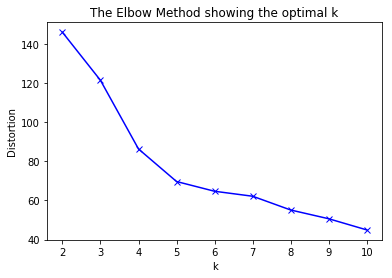

In [493]:
plt.plot(cluster_range, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

In [497]:
km = KMeans(n_clusters=5)
km.fit(X)

labels = km.labels_

In [498]:
data = data.assign(cluster=labels)

colors = ["red","green","yello","blue","black","orange","purple"]

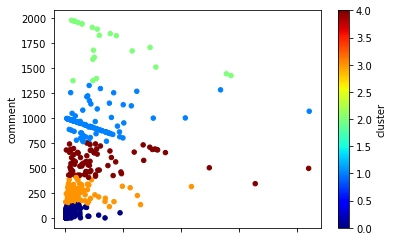

In [499]:
data.plot.scatter("post","comment",c="cluster",colormap='jet')

## Subreddits and Entities rank

In [303]:
def subreddit_count(authors):
    submission_type = "post"
    relevant_submissions_query = [{
            "$project":{
                "author_name":1,
                "subreddit_name_prefixed":1,
                "year":{"$year":"$created_date"},
                "dbpedia_entities":1,
                "type":1
            }
        },{"$match":{
            "type":submission_type,
            "author_name":{"$in":authors}
        }},{
            "$project":{
                "subreddit_name_prefixed":1,
                "author_name":1
            }
        },{
            "$group":{
                "_id":"$subreddit_name_prefixed",
                "authors":{"$addToSet":"$author_name"}
            }
        },{
            "$project":{
                "count":{"$size":"$authors"}
            }
        },{
        "$sort":{"count":-1}
        }]

    author_subreddit = list(db[COLLECTION].aggregate(relevant_submissions_query))
    return author_subreddit

In [304]:
entities_rank = {}
subreddit_rank = {}
for i in range(0,5):
    considered_authors = data.loc[data['cluster'] == i]
    subreddit_rank[str(i)] = subreddit_count(list(considered_authors.index))
    considered_data = author_df.loc[author_df.index.isin(considered_authors.index)]
    d = considered_data.sum().sort_values(ascending=False)
    entities_rank[str(i)] = d[d>0]

In [321]:
rank_0 = list(entities_rank["0"].keys())
rank_1 = list(entities_rank["1"].keys())
rank_2 = list(entities_rank["2"].keys())
rank_3 = list(entities_rank["3"].keys())
rank_4 = list(entities_rank["4"].keys())

In [306]:
rank_0 = list(map(lambda x: x["_id"], subreddit_rank["0"]))
rank_1 = list(map(lambda x: x["_id"], subreddit_rank["1"]))
rank_2 = list(map(lambda x: x["_id"], subreddit_rank["2"]))
rank_3 = list(map(lambda x: x["_id"], subreddit_rank["3"]))
rank_4 = list(map(lambda x: x["_id"], subreddit_rank["4"]))


In [322]:
common_0_1= [i for i in rank_0 if i in rank_1]
common_0_2= [i for i in rank_0 if i in rank_2]
common_0_3= [i for i in rank_0 if i in rank_3]
common_0_4= [i for i in rank_0 if i in rank_4]
common_1_0 = [i for i in rank_1 if i in rank_0]
common_1_2 = [i for i in rank_1 if i in rank_2]
common_1_3 = [i for i in rank_1 if i in rank_3]
common_1_4 = [i for i in rank_1 if i in rank_4]
common_2_0 = [i for i in rank_2 if i in rank_0]
common_2_1= [i for i in rank_2 if i in rank_1]
common_2_3 = [i for i in rank_2 if i in rank_3]
common_2_4 = [i for i in rank_2 if i in rank_4]
common_3_0 = [i for i in rank_3 if i in rank_0]
common_3_1 = [i for i in rank_3 if i in rank_1]
common_3_2 = [i for i in rank_3 if i in rank_2]
common_3_4 = [i for i in rank_3 if i in rank_4]
common_4_0 = [i for i in rank_4 if i in rank_0]
common_4_1 = [i for i in rank_4 if i in rank_1]
common_4_2 = [i for i in rank_4 if i in rank_2]
common_4_3 = [i for i in rank_4 if i in rank_3]

In [323]:
corr_0_1, p_value_0_1 = spearmanr(common_0_1, common_1_0)
corr_0_2, p_value_0_2 = spearmanr(common_0_2, common_2_0)
corr_0_3, p_value_0_3 = spearmanr(common_0_3, common_3_0)
corr_0_4, p_value_0_4 = spearmanr(common_0_4, common_4_0)

corr_1_2, p_value_1_2 = spearmanr(common_1_2, common_2_1)
corr_1_3, p_value_1_3 = spearmanr(common_1_3, common_3_1)
corr_1_4, p_value_1_4 = spearmanr(common_1_4, common_4_1)

corr_2_3, p_value_2_3 = spearmanr(common_2_3, common_3_2)
corr_2_4, p_value_2_4 = spearmanr(common_2_4, common_4_2)

corr_3_4, p_value_3_4 = spearmanr(common_4_3, common_3_4)



In [334]:
corr_3_4, p_value_3_4

(-0.04896507484830298, 0.20557672710240743)

In [310]:
common_0_1

['r/NEET',
 'r/depression',
 'r/AskReddit',
 'r/Advice',
 'r/ForeverAlone',
 'r/hikikomori',
 'r/NoFap',
 'r/Braincels',
 'r/jobs',
 'r/offmychest',
 'r/socialanxiety',
 'r/Anxiety',
 'r/SuicideWatch',
 'r/CircleofTrust',
 'r/techsupport',
 'r/aspergers',
 'r/videos',
 'r/mentalhealth',
 'r/MGTOW',
 'r/NoStupidQuestions',
 'r/vegan',
 'r/socialskills',
 'r/books',
 'r/Meditation',
 'r/confession',
 'r/relationships',
 'r/sex',
 'r/Showerthoughts',
 'r/anime',
 'r/FortNiteBR',
 'r/asktrp',
 'r/unpopularopinion',
 'r/raisedbynarcissists',
 'r/dating_advice',
 'r/lonely',
 'r/answers',
 'r/AskWomen',
 'r/AskOuija',
 'r/bipolar',
 'r/tipofmytongue',
 'r/askscience',
 'r/ADHD',
 'r/TrueOffMyChest',
 'r/redditrequest',
 'r/collapse',
 'r/getdisciplined',
 'r/CPTSD',
 'r/selfimprovement',
 'r/amiugly',
 'r/emulation',
 'r/OutOfTheLoop',
 'r/AvPD',
 'r/Dreams',
 'r/DeepIntoYouTube',
 'r/explainlikeimfive',
 'r/vaporents',
 'r/schizophrenia',
 'r/anime_irl',
 'r/DotA2',
 'r/AskDocs',
 'r/funny'

In [311]:
common_1_0

['r/NEET',
 'r/AskReddit',
 'r/Braincels',
 'r/unpopularopinion',
 'r/NoStupidQuestions',
 'r/Showerthoughts',
 'r/gaming',
 'r/depression',
 'r/ForeverAlone',
 'r/Advice',
 'r/askscience',
 'r/CircleofTrust',
 'r/AskDocs',
 'r/videos',
 'r/ADHD',
 'r/aspergers',
 'r/aww',
 'r/anime',
 'r/MGTOW',
 'r/SuicideWatch',
 'r/Anxiety',
 'r/explainlikeimfive',
 'r/OCD',
 'r/Jokes',
 'r/schizophrenia',
 'r/Drama',
 'r/OutOfTheLoop',
 'r/jobs',
 'r/techsupport',
 'r/vegan',
 'r/asexuality',
 'r/NoFap',
 'r/autism',
 'r/offmychest',
 'r/tipofmytongue',
 'r/socialanxiety',
 'r/2007scape',
 'r/college',
 'r/rant',
 'r/casualiama',
 'r/AskOuija',
 'r/changemyview',
 'r/getdisciplined',
 'r/raisedbynarcissists',
 'r/IncelTears',
 'r/answers',
 'r/IncelsWithoutHate',
 'r/4chan',
 'r/whatsthisbug',
 'r/Dreams',
 'r/selfimprovement',
 'r/PUBGMobile',
 'r/mensa',
 'r/nottheonion',
 'r/funny',
 'r/asktransgender',
 'r/PS4',
 'r/AskScienceDiscussion',
 'r/tressless',
 'r/Dogfree',
 'r/DeepIntoYouTube',
 'r

## Cluster with entities count

In [342]:
considered_authors = data.loc[data['cluster'] == 3]
considered_data = author_df.loc[author_df.index.isin(considered_authors.index)]
X = considered_data.values
pca = PCA(0.9)
X = pca.fit_transform(X)
cluster_range = range(2,11)
distortions = []
for k in cluster_range:
    km = KMeans(n_clusters=k)
    km.fit(X)

    labels = km.labels_
    distortions.append(sum(np.min(
        cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

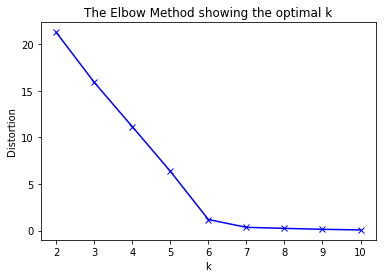

In [343]:
plt.plot(cluster_range, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

In [344]:
X.shape

(12, 5)

## Topic Modeling

In [222]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [223]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use',"rimosso","x200b","not","www","http","https"])

In [224]:
submissions = list(db[COLLECTION].find({"body":{"$ne":""},"selftext":{"$ne":""}},{"type":1,"title":1,"selftext":1,"body":1}))
data_text = []
for s in submissions:
    if s["type"] == "post":
        
        text = s["title"] + " " + s["selftext"]
    else:
        text = s["body"]
        
    data_text.append(text)

In [225]:
# Remove Emails
data_text = [re.sub('\S*@\S*\s?', '', sent) for sent in data_text]

# Remove URLS
data_text = [re.sub('^https?:\/\/.*[\r\n]*', '', sent) for sent in data_text]

# Remove new line characters
data_text = [re.sub('\s+', ' ', sent) for sent in data_text]

# Remove distracting single quotes
data_text = [re.sub("\'", "", sent) for sent in data_text]

In [226]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [227]:
data_words = list(sent_to_words(data_text))

print(data_words[:1])

[['the', 'strands', 'are', 'cheese', 'and', 'the', 'baby', 'is', 'just', 'mountain', 'dew']]


In [228]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['the', 'strands', 'are', 'cheese', 'and', 'the', 'baby', 'is', 'just', 'mountain_dew']


In [229]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [230]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['strand', 'cheese', 'baby', 'mountain_dew']]


In [231]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [521]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [522]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"credit" + 0.009*"escape" + 0.007*"book" + 0.007*"cost" + '
  '0.006*"student" + 0.006*"living" + 0.005*"team" + 0.005*"personality" + '
  '0.004*"weekend" + 0.004*"quiet"'),
 (1,
  '0.043*"age" + 0.037*"ability" + 0.033*"learn" + 0.012*"watch" + '
  '0.011*"neet" + 0.008*"post" + 0.006*"kid" + 0.006*"free" + 0.006*"dopamine" '
  '+ 0.005*"wonder"'),
 (2,
  '0.039*"new" + 0.035*"language" + 0.035*"disappear" + 0.034*"speaker" + '
  '0.034*"native" + 0.015*"game" + 0.013*"play" + 0.010*"deck" + 0.009*"video" '
  '+ 0.008*"card"'),
 (3,
  '0.033*"not" + 0.030*"be" + 0.020*"do" + 0.016*"would" + 0.015*"get" + '
  '0.015*"go" + 0.012*"feel" + 0.011*"want" + 0.011*"make" + 0.011*"time"'),
 (4,
  '0.046*"work" + 0.040*"job" + 0.029*"neet" + 0.019*"get" + 0.015*"college" + '
  '0.013*"year" + 0.010*"money" + 0.009*"parent" + 0.008*"live" + 0.008*"pay"')]


In [469]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.280776446762582

Coherence Score:  0.4033183909210919


In [249]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [250]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(4,
  [('country', 0.017915694414982274),
   ('world', 0.014109518470256674),
   ('live', 0.012164004969847571),
   ('state', 0.011654898633291918),
   ('american', 0.010509409376041699),
   ('city', 0.010254856207763872),
   ('make', 0.009533622230976696),
   ('good', 0.008460862450377284),
   ('war', 0.007854783478287221),
   ('government', 0.00775175005303191)]),
 (15,
  [('fuck', 0.07206516005726851),
   ('shit', 0.05227464224306236),
   ('kill', 0.01795463731084608),
   ('die', 0.016207810712499743),
   ('hell', 0.015036409346549847),
   ('stupid', 0.014748696730351627),
   ('suck', 0.01365264866864412),
   ('literally', 0.013179977942032758),
   ('give', 0.013104624637790368),
   ('hate', 0.012775810219278115)]),
 (6,
  [('eat', 0.025393067851107058),
   ('day', 0.019938622233882236),
   ('food', 0.01481974094433903),
   ('high', 0.013196829832278848),
   ('drug', 0.011305467258073373),
   ('week', 0.009798478368303203),
   ('low', 0.009798478368303203),
   ('make', 0.0095666339

In [232]:
mallet_path = 'mallet-2.0.8/bin/mallet'
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [233]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)



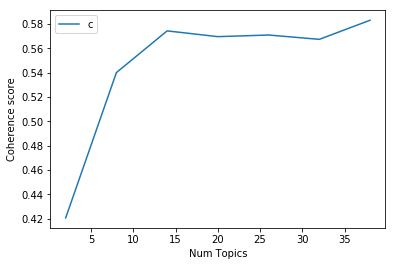

In [234]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [235]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4206
Num Topics = 8  has Coherence Value of 0.5401
Num Topics = 14  has Coherence Value of 0.5744
Num Topics = 20  has Coherence Value of 0.5697
Num Topics = 26  has Coherence Value of 0.571
Num Topics = 32  has Coherence Value of 0.5675
Num Topics = 38  has Coherence Value of 0.5832


In [251]:
optimal_model = ldamallet
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.087*"game" + 0.061*"play" + 0.015*"player" + 0.012*"run" + 0.011*"team" + '
  '0.010*"fun" + 0.010*"make" + 0.009*"good" + 0.007*"win" + 0.007*"update"'),
 (1,
  '0.074*"life" + 0.018*"experience" + 0.017*"anxiety" + 0.015*"depression" + '
  '0.013*"feeling" + 0.012*"happy" + 0.011*"live" + 0.010*"problem" + '
  '0.010*"pain" + 0.010*"thought"'),
 (2,
  '0.016*"lol" + 0.013*"wait" + 0.013*"good" + 0.012*"cool" + 0.011*"make" + '
  '0.010*"op" + 0.010*"nice" + 0.009*"edit" + 0.009*"sound" + 0.009*"feel"'),
 (3,
  '0.062*"job" + 0.053*"year" + 0.027*"neet" + 0.024*"live" + 0.024*"time" + '
  '0.021*"money" + 0.020*"month" + 0.018*"school" + 0.017*"pay" + '
  '0.016*"hour"'),
 (4,
  '0.018*"country" + 0.014*"world" + 0.012*"live" + 0.012*"state" + '
  '0.011*"american" + 0.010*"city" + 0.010*"make" + 0.008*"good" + 0.008*"war" '
  '+ 0.008*"government"'),
 (5,
  '0.061*"people" + 0.052*"friend" + 0.046*"talk" + 0.021*"family" + '
  '0.021*"person" + 0.021*"kid" + 0.018*"social" 

In [216]:
optimal_model.save("overall_post_comment_20_v2")


In [252]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.0833,"eat, day, food, high, drug, week, low, make, g...",The strands are cheese and the baby is just mo...
1,1,19.0,0.0657,"post, question, reddit, comment, action, rule,...","Yeah, thats why it actually contains a gif fro..."
2,2,18.0,0.0932,"watch, love, youtube, show, video, story, char...",Why not link to the actual trailer instead of ...
3,3,14.0,0.0829,"day, time, start, back, leave, year, ago, slee...","Meh, gotta look at the brightside, imagine wai..."
4,4,9.0,0.1182,"face, hand, head, side, big, eye, make, body, ...",Hairy German penetrates brunette in latex.
5,5,11.0,0.0785,"human, world, exist, god, make, true, good, an...",Nowhere in my post did I say or imply we dont ...
6,6,6.0,0.1230,"eat, day, food, high, drug, week, low, make, g...",I was meant to elminate certain food groups to...
7,7,6.0,0.2898,"eat, day, food, high, drug, week, low, make, g...",How beneficial is optimal nutrition? By optima...
8,8,9.0,0.1011,"face, hand, head, side, big, eye, make, body, ...","Everytime you mock Hashimoto, he makes Clouds ..."
9,9,3.0,0.1499,"job, year, neet, live, time, money, month, sch...",">Honestly, get a job at an agency to start out..."


In [254]:
i = 0
for s in submissions:
    d = df_dominant_topic.iloc[i]
    
    topic_number = d["Dominant_Topic"]
    keyword = d["Keywords"]
    prob = d["Topic_Perc_Contrib"]
    
    _id = s["_id"]
    
    db[COLLECTION].update({"_id":_id},{"$set":{"topic_number":topic_number,"keyword":keyword,"probability":prob}})
    i = i +1

In [253]:
submissions[10]

{'_id': ObjectId('5bfc07001d41c832105a2c1b'),
 'title': 'Working in PPC - The good and the bad?',
 'selftext': "Working PPC seems like an interesting job. There are plenty of courses and it is something you can actually get experience in without getting a job through doing your own ecommerce stuff. \n\n\nYou are literally spending the company's money and your losses and gains can be directly tracked and is a measure of your performance. So it's a job where you're constantly being tracked and will be held responsible if lose the company money. I'm worried that this will be a high stress position and cutthroat.\n\nAny thoughts on this from someone who works in the field?",
 'type': 'post'}

In [248]:
df_dominant_topic.to_pickle("overall_document_topic_new.pkl")

In [255]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6149,"game, play, player, run, team, fun, make, good...",for leagueclient.log 000008.049| ERROR| <unkno...
1,1.0,0.6452,"life, experience, anxiety, depression, feeling...",Τι ειπες για μενα καριολακι; Αν θες να ξερεις ...
2,2.0,0.9022,"lol, wait, good, cool, make, op, nice, edit, s...",> Parece-me um sistema comuna moderno. É preci...
3,3.0,0.5869,"job, year, neet, live, time, money, month, sch...",Ive gathered all major WoW private servers - a...
4,4.0,0.6500,"country, world, live, state, american, city, m...","40 percent is still a large number, don’t you ..."
5,5.0,0.3554,"people, friend, talk, family, person, kid, soc...",I feel I have no control whether I get out of ...
6,6.0,0.5948,"eat, day, food, high, drug, week, low, make, g...",^CONTINUE ^\(1) **A) Diet:** Myth busting: The...
7,7.0,0.5324,"read, learn, write, book, word, find, type, ma...",[For Hire] (Native Mandarin Chinese speaker)(T...
8,8.0,0.5384,"buy, money, free, high, number, sell, order, p...",` gyp libc-dev-bin libc6-dev libjs-inherits li...
9,9.0,0.5964,"face, hand, head, side, big, eye, make, body, ...","**TL;DR - /r/flexibility. Also, mobilise your ..."


In [257]:
pd.set_option('display.max_colwidth', -1)
sent_topics_sorteddf_mallet.head(20)

Topic_Num  Topic_Perc_Contrib  \
0   0.0        0.6149               
1   1.0        0.6452               
2   2.0        0.9022               
3   3.0        0.5869               
4   4.0        0.6500               
5   5.0        0.3554               
6   6.0        0.5948               
7   7.0        0.5324               
8   8.0        0.5384               
9   9.0        0.5964               
10  10.0       0.4274               
11  11.0       0.5731               
12  12.0       0.5268               
13  13.0       0.7068               
14  14.0       0.4918               
15  15.0       0.7876               
16  16.0       0.6283               
17  17.0       0.3648               
18  18.0       0.7806               
19  19.0       0.8942               

                                                                               Keywords  \
0   game, play, player, run, team, fun, make, good, win, update                           
1   life, experience, anxiety, depression, feeling, happy, live, problem, pain, thought   
2   lol, wait, good, cool, make, op, nice, edit, sound, feel                              
3   job, year, neet, live, time, money, month, school, pay, hour                          
4   country, world, live, state, american, city, make, good, war, government              
5   people, friend, talk, family, person, kid, social, life, parent, love                 
6   eat, day, food, high, drug, week, low, make, good, drink                              
7   read, learn, write, book, word, find, type, make, art, good                           
8   buy, money, free, high, number, sell, order, pay, make, cost                          
9   face, hand, head, side, big, eye, make, body, small, back                             
10  time, point, change, lot, happen, part, bad, put, sound, reason                       
11  human, world, exist, god, make, true, good, animal, religion, fact                    
12  man, woman, guy, girl, sex, date, incel, female, male, ugly                           
13  find, give, pretty, ill, bad, hope, great, time, place, hard                          
14  day, time, start, back, leave, year, ago, sleep, long, night                          
15  fuck, shit, kill, die, hell, stupid, suck, literally, give, hate                      
16  fight, kill, level, hit, make, damage, attack, good, power, shoot                     
17  people, problem, call, care, person, white, agree, hate, black, opinion               
18  watch, love, youtube, show, video, story, character, movie, music, listen             
19  post, question, reddit, comment, action, rule, concern, link, moderator, subreddit    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

"[Something that looks like this.](https://images.sftcdn.net/images/t_app-cover-l,f_auto/p/0d793d4c-9a9a-11e6-a071-00163ec9f5fa/1246904121/nexusfile-screenshot.jpg) That's from NexusFile, although it only allows you to view your folders like that, not manage them."

In [156]:
sent_topics_sorteddf_mallet.to_pickle("overall_most_relevant_document_per_topic.pkl")

In [258]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_topic_distribution = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_topic_distribution.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_topic_distribution



,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"game, play, player, run, team, fun, make, good, win, update",30846,0.1229
1,1.0,"life, experience, anxiety, depression, feeling, happy, live, problem, pain, thought",11213,0.0447
2,2.0,"lol, wait, good, cool, make, op, nice, edit, sound, feel",11806,0.0470
3,3.0,"job, year, neet, live, time, money, month, school, pay, hour",11934,0.0475
4,4.0,"country, world, live, state, american, city, make, good, war, government",14274,0.0569
5,5.0,"people, friend, talk, family, person, kid, social, life, parent, love",10772,0.0429
6,6.0,"eat, day, food, high, drug, week, low, make, good, drink",13730,0.0547
7,7.0,"read, learn, write, book, word, find, type, make, art, good",9507,0.0379
8,8.0,"buy, money, free, high, number, sell, order, pay, make, cost",10947,0.0436
9,9.0,"face, hand, head, side, big, eye, make, body, small, back",11050,0.0440


In [158]:
df_topic_distribution.to_pickle("overall_topic_distribution.pkl")

In [159]:
len(submissions)

18366

In [163]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
for s in submissions:
    text = [s["selftext"]]
    # Remove Emails
    text = [re.sub('\S*@\S*\s?', '', sent) for sent in text]

    # Remove URLS
    text = [re.sub('^https?:\/\/.*[\r\n]*', '', sent) for sent in text]

    # Remove new line characters
    text = [re.sub('\s+', ' ', sent) for sent in text]

    # Remove distracting single quotes
    text = [re.sub("\'", "", sent) for sent in text]

    text = list(sent_to_words(text))

    # Remove Stop Words
    text = remove_stopwords(text)

    # Form Bigrams
    texts = make_bigrams(text)

    
    # Do lemmatization keeping only noun, adj, vb, adv
    texts_lemmatized = lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    bow = id2word.doc2bow(texts_lemmatized[0])
    topic = sorted(optimal_model[bow],key=lambda x: -x[1])[0] #get the most relevant topic
    
    db[COLLECTION].update({"_id":s["_id"]},{"$set":{"topic":{"topic_number":topic[0],"probability":topic[1]}}})

CalledProcessError: Command 'mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/rp/tyhpfn5x0msg_mb3s4zckkk92vbt2s/T/762f19_corpus.txt --output /var/folders/rp/tyhpfn5x0msg_mb3s4zckkk92vbt2s/T/762f19_corpus.mallet.infer --use-pipe-from /var/folders/rp/tyhpfn5x0msg_mb3s4zckkk92vbt2s/T/762f19_corpus.mallet' returned non-zero exit status 1.

In [164]:
bow = id2word.doc2bow(texts_lemmatized[0])
t = sorted(optimal_model[bow],key=lambda x: -x[1])[0]
t[1]

CalledProcessError: Command 'mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/rp/tyhpfn5x0msg_mb3s4zckkk92vbt2s/T/762f19_corpus.txt --output /var/folders/rp/tyhpfn5x0msg_mb3s4zckkk92vbt2s/T/762f19_corpus.mallet.infer --use-pipe-from /var/folders/rp/tyhpfn5x0msg_mb3s4zckkk92vbt2s/T/762f19_corpus.mallet' returned non-zero exit status 1.

In [162]:
optimal_model